In [169]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import hyptorch.nn as hypnn

# This is the base neural network with hyperbolic embedding
class Net(nn.Module):
    def __init__(self, input_channels, num_classes, dim, c, train_x, train_c):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        self.fc1 = nn.Linear(5 * 5 * 50, 500)  
        self.fc2 = nn.Linear(500, dim)
        self.tp = hypnn.ToPoincare(c=c, train_x=train_x, train_c=train_c, ball_dim=dim)
        self.mlr = hypnn.HyperbolicMLR(ball_dim=dim, n_classes=num_classes, c=c)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tp(x)
        return F.log_softmax(self.mlr(x, c=self.tp.c), dim=-1)

In [45]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

# Augmented data transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),  # Randomly crop and resize the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly alter the brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Standard transformations for the test set (unchanged)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Applying the transformations to CIFAR10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [170]:
net = Net(input_channels=3, num_classes=10, dim=20 , c=1, train_x=True, train_c=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)  # Move your model to the appropriate device

optimizer = Adam(net.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*target.shape[0]
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f'Train Epoch: {epoch} \tLoss: {train_loss:.6f} \tAccuracy: {accuracy:.2f}%')
    train_loss_list.append(train_loss)
    train_acc_list.append(accuracy)

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()*target.shape[0]  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    test_loss_list.append(test_loss)
    test_acc_list.append(accuracy)

N_ep = 50

# Example training call
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(net, device, train_loader, optimizer, criterion, epoch)
    test(net, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.791716 	Accuracy: 34.57%

Test set: Average loss: 1.5023, Accuracy: 4616/10000 (46.16%)

Train Epoch: 2 	Loss: 1.577456 	Accuracy: 43.50%

Test set: Average loss: 1.3544, Accuracy: 5164/10000 (51.64%)

Train Epoch: 3 	Loss: 1.407044 	Accuracy: 50.25%

Test set: Average loss: 1.6512, Accuracy: 3867/10000 (38.67%)

Train Epoch: 4 	Loss: 1.424316 	Accuracy: 50.39%

Test set: Average loss: 1.5782, Accuracy: 4552/10000 (45.52%)

Train Epoch: 5 	Loss: 1.363899 	Accuracy: 52.72%

Test set: Average loss: 1.1487, Accuracy: 5927/10000 (59.27%)

Train Epoch: 6 	Loss: 1.195642 	Accuracy: 58.67%

Test set: Average loss: 1.0399, Accuracy: 6452/10000 (64.52%)

Train Epoch: 7 	Loss: 1.094722 	Accuracy: 62.26%

Test set: Average loss: 0.9834, Accuracy: 6635/10000 (66.35%)

Train Epoch: 8 	Loss: 1.030606 	Accuracy: 64.49%

Test set: Average loss: 0.9590, Accuracy: 6802/10000 (68.02%)

Train Epoch: 9 	Loss: 0.968106 	Accuracy: 66.82%

Test set: Average loss: 0.9200, Accuracy: 6932

In [28]:
import seaborn as sns

In [176]:
# The number of trainable parameters
sum(p.numel() for p in net.parameters() if p.requires_grad)

662511

Second hyperbolic network with more trainable parameters.

In [177]:
# Second hyperbolic net with more parameters
class Net2(nn.Module):
    def __init__(self, input_channels, num_classes, dim, c, train_x, train_c):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 30, 5, 1)
        self.conv2 = nn.Conv2d(30, 60, 5, 1)
        
        self.fc1 = nn.Linear(5 * 5 * 60, 750)  
        self.fc2 = nn.Linear(750, dim)
        self.tp = hypnn.ToPoincare(c=c, train_x=train_x, train_c=train_c, ball_dim=dim)
        self.mlr = hypnn.HyperbolicMLR(ball_dim=dim, n_classes=num_classes, c=c)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 60)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tp(x)
        return F.log_softmax(self.mlr(x, c=self.tp.c), dim=-1)

In [178]:
net2 = Net2(input_channels=3, num_classes=10, dim=25 , c=1, train_x=True, train_c=True)

In [179]:
# The number of trainable parameters
sum(p.numel() for p in net2.parameters() if p.requires_grad)

1192391

In [180]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2.to(device)  # Move your model to the appropriate device

optimizer = Adam(net2.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [181]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(net2, device, train_loader, optimizer, criterion, epoch)
    test(net2, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.849532 	Accuracy: 32.83%

Test set: Average loss: 1.5940, Accuracy: 4300/10000 (43.00%)

Train Epoch: 2 	Loss: 1.625937 	Accuracy: 41.94%

Test set: Average loss: 1.4483, Accuracy: 4775/10000 (47.75%)

Train Epoch: 3 	Loss: 1.540505 	Accuracy: 45.59%

Test set: Average loss: 1.3838, Accuracy: 5081/10000 (50.81%)

Train Epoch: 4 	Loss: 1.471791 	Accuracy: 48.60%

Test set: Average loss: 1.2647, Accuracy: 5497/10000 (54.97%)

Train Epoch: 5 	Loss: 1.359722 	Accuracy: 52.64%

Test set: Average loss: 1.2400, Accuracy: 5658/10000 (56.58%)

Train Epoch: 6 	Loss: 1.203619 	Accuracy: 58.24%

Test set: Average loss: 1.2112, Accuracy: 5879/10000 (58.79%)

Train Epoch: 7 	Loss: 1.184152 	Accuracy: 58.90%

Test set: Average loss: 1.1158, Accuracy: 6102/10000 (61.02%)

Train Epoch: 8 	Loss: 1.058934 	Accuracy: 63.21%

Test set: Average loss: 0.9546, Accuracy: 6693/10000 (66.93%)

Train Epoch: 9 	Loss: 1.074382 	Accuracy: 63.18%

Test set: Average loss: 1.0026, Accuracy: 6534

<Axes: >

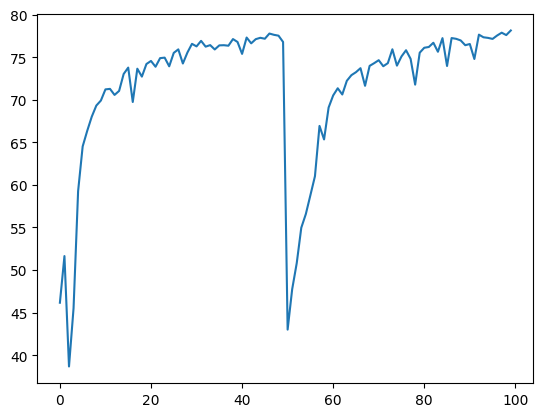

In [185]:
sns.lineplot(test_acc_list)

Third net with more parameters

In [186]:
# The third hyperbolic net with more parameters
class Net3(nn.Module):
    def __init__(self, input_channels, num_classes, dim, c, train_x, train_c):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 750)  
        self.fc2 = nn.Linear(750, dim)
        self.tp = hypnn.ToPoincare(c=c, train_x=train_x, train_c=train_c, ball_dim=dim)
        self.mlr = hypnn.HyperbolicMLR(ball_dim=dim, n_classes=num_classes, c=c)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tp(x)
        return F.log_softmax(self.mlr(x, c=self.tp.c), dim=-1)

In [187]:
net3 = Net3(input_channels=3, num_classes=10, dim=30 , c=1, train_x=True, train_c=True)

In [188]:
# The number of trainable parameters
sum(p.numel() for p in net3.parameters() if p.requires_grad)

1653159

In [189]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net3.to(device)  # Move your model to the appropriate device

optimizer = Adam(net3.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [190]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(net3, device, train_loader, optimizer, criterion, epoch)
    test(net3, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.779493 	Accuracy: 34.75%

Test set: Average loss: 1.5418, Accuracy: 4304/10000 (43.04%)

Train Epoch: 2 	Loss: 1.551863 	Accuracy: 43.74%

Test set: Average loss: 1.4383, Accuracy: 4869/10000 (48.69%)

Train Epoch: 3 	Loss: 1.423408 	Accuracy: 49.24%

Test set: Average loss: 1.2592, Accuracy: 5554/10000 (55.54%)

Train Epoch: 4 	Loss: 1.379208 	Accuracy: 51.46%

Test set: Average loss: 1.2450, Accuracy: 5645/10000 (56.45%)

Train Epoch: 5 	Loss: 1.310266 	Accuracy: 54.63%

Test set: Average loss: 1.3037, Accuracy: 5453/10000 (54.53%)

Train Epoch: 6 	Loss: 1.265707 	Accuracy: 55.66%

Test set: Average loss: 1.1531, Accuracy: 5967/10000 (59.67%)

Train Epoch: 7 	Loss: 1.183583 	Accuracy: 58.80%

Test set: Average loss: 1.0801, Accuracy: 6201/10000 (62.01%)

Train Epoch: 8 	Loss: 1.179043 	Accuracy: 59.10%

Test set: Average loss: 1.1301, Accuracy: 6122/10000 (61.22%)

Train Epoch: 9 	Loss: 1.139765 	Accuracy: 60.36%

Test set: Average loss: 1.0775, Accuracy: 6339

<Axes: >

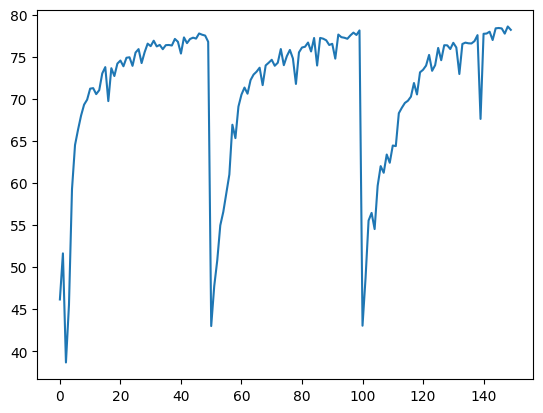

In [193]:
sns.lineplot(test_acc_list)

In [195]:
import numpy as np

In [197]:
np.max(test_acc_list[:50]),np.max(test_acc_list[50:100]),np.max(test_acc_list[100:150])

(77.78, 78.14, 78.61)

In [198]:
np.max(train_acc_list[:50]),np.max(train_acc_list[50:100]),np.max(train_acc_list[100:150])

(83.278, 83.384, 84.256)

Let's now create and train usual neural networks (Euclidian) to compare with.

In [199]:
# First Euclidean net with the ~same number of parameters as Net1
class NetEuclidean(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_dim):
        super(NetEuclidean, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 50, 500)  
        self.fc2 = nn.Linear(500, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Final layer for Euclidean output

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Fully connected layers
        x = x.view(-1, 5 * 5 * 50)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)


In [206]:
Eucl_net = NetEuclidean(input_channels=3, num_classes=10, hidden_dim=20)

In [207]:
# The number of trainable parameters
sum(p.numel() for p in Eucl_net.parameters() if p.requires_grad)

662300

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eucl_net.to(device)  # Move your model to the appropriate device

optimizer = Adam(Eucl_net.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [209]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(Eucl_net, device, train_loader, optimizer, criterion, epoch)
    test(Eucl_net, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.671009 	Accuracy: 39.27%

Test set: Average loss: 1.3300, Accuracy: 5134/10000 (51.34%)

Train Epoch: 2 	Loss: 1.334651 	Accuracy: 52.66%

Test set: Average loss: 1.1730, Accuracy: 5855/10000 (58.55%)

Train Epoch: 3 	Loss: 1.191765 	Accuracy: 58.17%

Test set: Average loss: 1.1051, Accuracy: 6210/10000 (62.10%)

Train Epoch: 4 	Loss: 1.106840 	Accuracy: 61.48%

Test set: Average loss: 1.0758, Accuracy: 6335/10000 (63.35%)

Train Epoch: 5 	Loss: 1.028463 	Accuracy: 64.12%

Test set: Average loss: 0.9204, Accuracy: 6814/10000 (68.14%)

Train Epoch: 6 	Loss: 0.971684 	Accuracy: 66.16%

Test set: Average loss: 0.9496, Accuracy: 6804/10000 (68.04%)

Train Epoch: 7 	Loss: 0.926816 	Accuracy: 67.88%

Test set: Average loss: 0.9183, Accuracy: 6881/10000 (68.81%)

Train Epoch: 8 	Loss: 0.888256 	Accuracy: 69.14%

Test set: Average loss: 0.8809, Accuracy: 7018/10000 (70.18%)

Train Epoch: 9 	Loss: 0.852116 	Accuracy: 70.39%

Test set: Average loss: 0.8578, Accuracy: 7141

<Axes: >

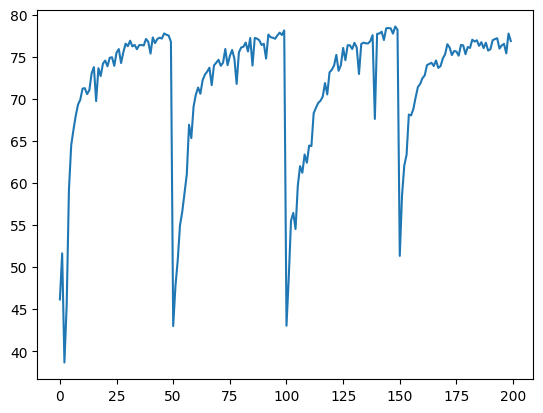

In [210]:
sns.lineplot(test_acc_list)

Euclidian net with more trainable parameters

In [216]:
# Second Euclidean net with more parameters, the same as Net2
class NetEuclidean2(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_dim):
        super(NetEuclidean2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 30, 5, 1)
        self.conv2 = nn.Conv2d(30, 60, 5, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(5 * 5 * 60, 750)  
        self.fc2 = nn.Linear(750, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Final layer for Euclidean output

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # Fully connected layers
        x = x.view(-1, 5 * 5 * 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)


In [217]:
Eucl_net2 = NetEuclidean2(input_channels=3, num_classes=10, hidden_dim=25)

In [218]:
sum(p.numel() for p in Eucl_net2.parameters() if p.requires_grad)

1192125

In [219]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eucl_net2.to(device)  # Move your model to the appropriate device

optimizer = Adam(Eucl_net2.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [220]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(Eucl_net2, device, train_loader, optimizer, criterion, epoch)
    test(Eucl_net2, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.603519 	Accuracy: 41.68%

Test set: Average loss: 1.3468, Accuracy: 5284/10000 (52.84%)

Train Epoch: 2 	Loss: 1.250378 	Accuracy: 55.92%

Test set: Average loss: 1.0649, Accuracy: 6262/10000 (62.62%)

Train Epoch: 3 	Loss: 1.116449 	Accuracy: 60.72%

Test set: Average loss: 1.0220, Accuracy: 6428/10000 (64.28%)

Train Epoch: 4 	Loss: 1.018767 	Accuracy: 64.41%

Test set: Average loss: 0.9543, Accuracy: 6715/10000 (67.15%)

Train Epoch: 5 	Loss: 0.947280 	Accuracy: 66.94%

Test set: Average loss: 0.8829, Accuracy: 6993/10000 (69.93%)

Train Epoch: 6 	Loss: 0.889921 	Accuracy: 68.80%

Test set: Average loss: 0.9188, Accuracy: 6938/10000 (69.38%)

Train Epoch: 7 	Loss: 0.843473 	Accuracy: 70.55%

Test set: Average loss: 0.8176, Accuracy: 7166/10000 (71.66%)

Train Epoch: 8 	Loss: 0.810226 	Accuracy: 71.89%

Test set: Average loss: 0.8129, Accuracy: 7197/10000 (71.97%)

Train Epoch: 9 	Loss: 0.782324 	Accuracy: 73.01%

Test set: Average loss: 0.8119, Accuracy: 7316

<Axes: >

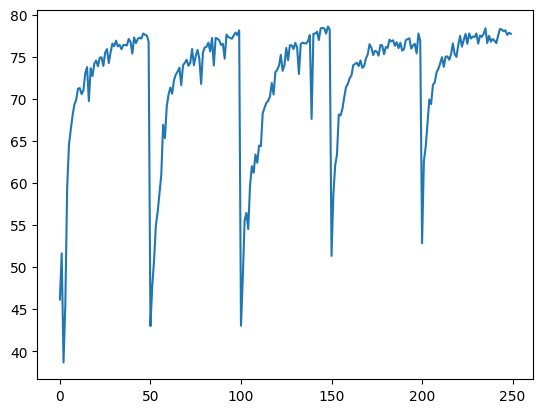

In [221]:
sns.lineplot(test_acc_list)

And the last Euclidian net

In [223]:
# Third Euclidean net with more parameters, ~same as for Net3
class NetEuclidean3(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_dim):
        super(NetEuclidean3, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 750)  
        self.fc2 = nn.Linear(750, hidden_dim)  # Use dim as an intermediate feature size
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Final layer outputs num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Directly output to fc3, which outputs num_classes
        return F.log_softmax(x, dim=-1)  # Apply log_softmax for the classification

In [224]:
Eucl_net3 = NetEuclidean3(input_channels=3, num_classes=10, hidden_dim=30)

In [225]:
sum(p.numel() for p in Eucl_net3.parameters() if p.requires_grad)

1652838

In [226]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eucl_net3.to(device)  # Move your model to the appropriate device

optimizer = Adam(Eucl_net3.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [227]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(Eucl_net3, device, train_loader, optimizer, criterion, epoch)
    test(Eucl_net3, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.648784 	Accuracy: 39.14%

Test set: Average loss: 1.3178, Accuracy: 5209/10000 (52.09%)

Train Epoch: 2 	Loss: 1.282317 	Accuracy: 54.24%

Test set: Average loss: 1.0637, Accuracy: 6225/10000 (62.25%)

Train Epoch: 3 	Loss: 1.110813 	Accuracy: 60.72%

Test set: Average loss: 0.9679, Accuracy: 6615/10000 (66.15%)

Train Epoch: 4 	Loss: 0.999669 	Accuracy: 65.21%

Test set: Average loss: 0.8892, Accuracy: 6933/10000 (69.33%)

Train Epoch: 5 	Loss: 0.930037 	Accuracy: 67.52%

Test set: Average loss: 0.9149, Accuracy: 6907/10000 (69.07%)

Train Epoch: 6 	Loss: 0.867419 	Accuracy: 69.75%

Test set: Average loss: 0.8023, Accuracy: 7265/10000 (72.65%)

Train Epoch: 7 	Loss: 0.820084 	Accuracy: 71.39%

Test set: Average loss: 0.7804, Accuracy: 7345/10000 (73.45%)

Train Epoch: 8 	Loss: 0.786734 	Accuracy: 72.64%

Test set: Average loss: 0.8029, Accuracy: 7333/10000 (73.33%)

Train Epoch: 9 	Loss: 0.752440 	Accuracy: 74.05%

Test set: Average loss: 0.7425, Accuracy: 7495

<Axes: >

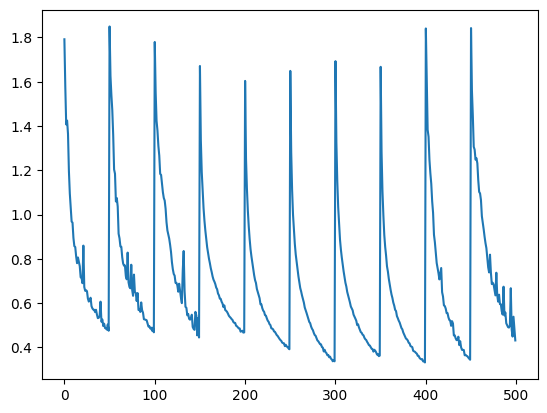

In [270]:
sns.lineplot(train_loss_list)

<Axes: >

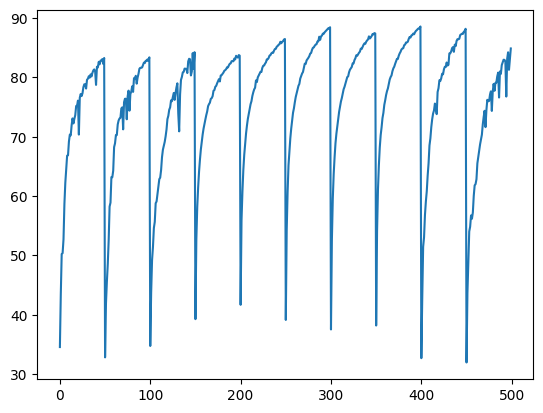

In [269]:
sns.lineplot(train_acc_list)

<Axes: >

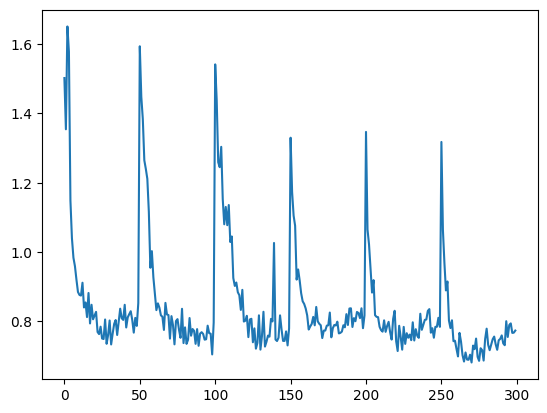

In [231]:
sns.lineplot(test_loss_list)

<Axes: >

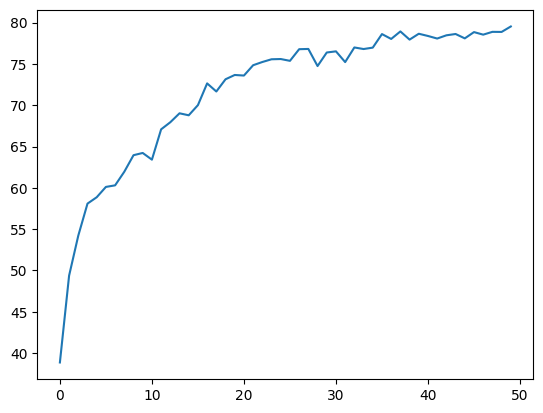

In [268]:
sns.lineplot(test_acc_list[-50:])

In [232]:
# Save results

np.savetxt('train_acc_history.csv',train_acc_list,delimiter=',')
np.savetxt('train_loss_history.csv',train_loss_list,delimiter=',')
np.savetxt('test_acc_history.csv',test_acc_list,delimiter=',')
np.savetxt('test_loss_history.csv',test_loss_list,delimiter=',')

<Axes: >

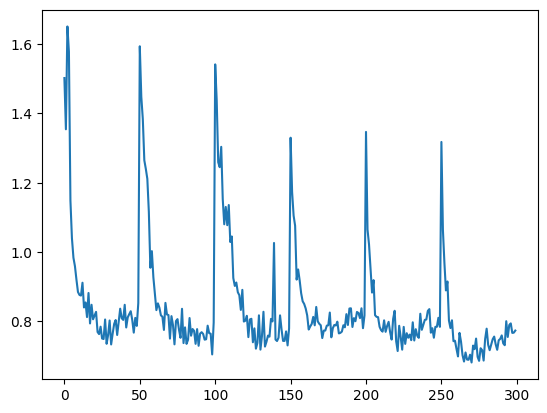

In [236]:
sns.lineplot(np.loadtxt('test_loss_history.csv',delimiter=','))

From this point we have been asked to conduct more experiments, so we repeat the same for two more Euclidean models and two more Hyperbolic models.

In [241]:
class NetEuclidean4(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_dim):
        super(NetEuclidean4, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 48, 3, 1)
        self.conv2 = nn.Conv2d(48, 96, 3, 1)
        self.conv3 = nn.Conv2d(96, 144, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 144, 800)  
        self.fc2 = nn.Linear(800, hidden_dim)  # Use dim as an intermediate feature size
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Final layer outputs num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 144)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Directly output to fc3, which outputs num_classes
        return F.log_softmax(x, dim=-1)  # Apply log_softmax for the classification

In [242]:
Eucl_net4 = NetEuclidean4(input_channels=3, num_classes=10, hidden_dim=35)

In [243]:
sum(p.numel() for p in Eucl_net4.parameters() if p.requires_grad)

2039867

In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eucl_net4.to(device)  # Move your model to the appropriate device

optimizer = Adam(Eucl_net4.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [245]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(Eucl_net4, device, train_loader, optimizer, criterion, epoch)
    test(Eucl_net4, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.692815 	Accuracy: 37.53%

Test set: Average loss: 1.3598, Accuracy: 4952/10000 (49.52%)

Train Epoch: 2 	Loss: 1.325715 	Accuracy: 52.60%

Test set: Average loss: 1.1220, Accuracy: 6030/10000 (60.30%)

Train Epoch: 3 	Loss: 1.149862 	Accuracy: 59.54%

Test set: Average loss: 1.0423, Accuracy: 6344/10000 (63.44%)

Train Epoch: 4 	Loss: 1.032497 	Accuracy: 63.74%

Test set: Average loss: 0.9031, Accuracy: 6831/10000 (68.31%)

Train Epoch: 5 	Loss: 0.954663 	Accuracy: 66.57%

Test set: Average loss: 0.8735, Accuracy: 7036/10000 (70.36%)

Train Epoch: 6 	Loss: 0.886343 	Accuracy: 68.94%

Test set: Average loss: 0.8361, Accuracy: 7123/10000 (71.23%)

Train Epoch: 7 	Loss: 0.841129 	Accuracy: 70.53%

Test set: Average loss: 0.8321, Accuracy: 7213/10000 (72.13%)

Train Epoch: 8 	Loss: 0.805179 	Accuracy: 71.74%

Test set: Average loss: 0.7865, Accuracy: 7339/10000 (73.39%)

Train Epoch: 9 	Loss: 0.773839 	Accuracy: 73.03%

Test set: Average loss: 0.7125, Accuracy: 7580

In [251]:
class NetEuclidean5(nn.Module):
    def __init__(self, input_channels, num_classes, hidden_dim):
        super(NetEuclidean5, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 172, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 172, 900)  
        self.fc2 = nn.Linear(900, hidden_dim)  # Use dim as an intermediate feature size
        self.fc3 = nn.Linear(hidden_dim, num_classes)  # Final layer outputs num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 172)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Directly output to fc3, which outputs num_classes
        return F.log_softmax(x, dim=-1)  # Apply log_softmax for the classification

In [252]:
Eucl_net5 = NetEuclidean5(input_channels=3, num_classes=10, hidden_dim=40)

In [253]:
sum(p.numel() for p in Eucl_net5.parameters() if p.requires_grad)

2788114

In [254]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Eucl_net5.to(device)  # Move your model to the appropriate device

optimizer = Adam(Eucl_net5.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [255]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(Eucl_net5, device, train_loader, optimizer, criterion, epoch)
    test(Eucl_net5, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.667185 	Accuracy: 38.20%

Test set: Average loss: 1.3811, Accuracy: 5016/10000 (50.16%)

Train Epoch: 2 	Loss: 1.281790 	Accuracy: 54.09%

Test set: Average loss: 1.0789, Accuracy: 6176/10000 (61.76%)

Train Epoch: 3 	Loss: 1.103928 	Accuracy: 61.10%

Test set: Average loss: 0.9711, Accuracy: 6657/10000 (66.57%)

Train Epoch: 4 	Loss: 0.996478 	Accuracy: 65.22%

Test set: Average loss: 0.8798, Accuracy: 6945/10000 (69.45%)

Train Epoch: 5 	Loss: 0.908151 	Accuracy: 68.23%

Test set: Average loss: 0.9613, Accuracy: 6816/10000 (68.16%)

Train Epoch: 6 	Loss: 0.853840 	Accuracy: 70.28%

Test set: Average loss: 0.8203, Accuracy: 7144/10000 (71.44%)

Train Epoch: 7 	Loss: 0.814233 	Accuracy: 71.59%

Test set: Average loss: 0.7888, Accuracy: 7342/10000 (73.42%)

Train Epoch: 8 	Loss: 0.765983 	Accuracy: 73.15%

Test set: Average loss: 0.7318, Accuracy: 7493/10000 (74.93%)

Train Epoch: 9 	Loss: 0.742324 	Accuracy: 74.03%

Test set: Average loss: 0.7209, Accuracy: 7544

Let's collect more data on Hyperbolic embeddings.

In [257]:
class Net4(nn.Module):
    def __init__(self, input_channels, num_classes, dim, c, train_x, train_c):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 48, 3, 1)
        self.conv2 = nn.Conv2d(48, 96, 3, 1)
        self.conv3 = nn.Conv2d(96, 144, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 144, 800)  
        self.fc2 = nn.Linear(800, dim)
        self.tp = hypnn.ToPoincare(c=c, train_x=train_x, train_c=train_c, ball_dim=dim)
        self.mlr = hypnn.HyperbolicMLR(ball_dim=dim, n_classes=num_classes, c=c)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 144)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tp(x)
        return F.log_softmax(self.mlr(x, c=self.tp.c), dim=-1)

In [258]:
net4 = Net4(input_channels=3, num_classes=10, dim=35, c=1, train_x=True, train_c=True)

In [259]:
sum(p.numel() for p in net4.parameters() if p.requires_grad)

2040243

In [260]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net4.to(device)  # Move your model to the appropriate device

optimizer = Adam(net4.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [261]:
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(net4, device, train_loader, optimizer, criterion, epoch)
    test(net4, device, test_loader, criterion)

Train Epoch: 1 	Loss: 1.840550 	Accuracy: 32.69%

Test set: Average loss: 1.6189, Accuracy: 4046/10000 (40.46%)

Train Epoch: 2 	Loss: 1.598982 	Accuracy: 42.81%

Test set: Average loss: 1.4677, Accuracy: 4851/10000 (48.51%)

Train Epoch: 3 	Loss: 1.382836 	Accuracy: 51.46%

Test set: Average loss: 1.2208, Accuracy: 5809/10000 (58.09%)

Train Epoch: 4 	Loss: 1.350900 	Accuracy: 53.08%

Test set: Average loss: 1.1773, Accuracy: 5920/10000 (59.20%)

Train Epoch: 5 	Loss: 1.246289 	Accuracy: 56.81%

Test set: Average loss: 1.1709, Accuracy: 5980/10000 (59.80%)

Train Epoch: 6 	Loss: 1.186323 	Accuracy: 59.08%

Test set: Average loss: 1.1400, Accuracy: 6126/10000 (61.26%)

Train Epoch: 7 	Loss: 1.139036 	Accuracy: 60.81%

Test set: Average loss: 1.0401, Accuracy: 6546/10000 (65.46%)

Train Epoch: 8 	Loss: 1.059771 	Accuracy: 63.47%

Test set: Average loss: 1.0051, Accuracy: 6594/10000 (65.94%)

Train Epoch: 9 	Loss: 1.007838 	Accuracy: 65.53%

Test set: Average loss: 0.9379, Accuracy: 6900

In [262]:
class Net5(nn.Module):
    def __init__(self, input_channels, num_classes, dim, c, train_x, train_c):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 172, 3, 1)
        
        self.fc1 = nn.Linear(4 * 4 * 172, 900)  
        self.fc2 = nn.Linear(900, dim)
        self.tp = hypnn.ToPoincare(c=c, train_x=train_x, train_c=train_c, ball_dim=dim)
        self.mlr = hypnn.HyperbolicMLR(ball_dim=dim, n_classes=num_classes, c=c)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 4 * 4 * 172)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tp(x)
        return F.log_softmax(self.mlr(x, c=self.tp.c), dim=-1)

In [263]:
net5 = Net5(input_channels=3, num_classes=10, dim=40, c=1, train_x=True, train_c=True)

In [264]:
sum(p.numel() for p in net5.parameters() if p.requires_grad)

2788545

In [265]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net5.to(device)  # Move your model to the appropriate device

optimizer = Adam(net5.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [316]:
# I run this cell twice to better train.
for epoch in range(1, N_ep + 1):  # Adjust the range according to your needs
    train(net5, device, train_loader, optimizer, criterion, epoch)
    test(net5, device, test_loader, criterion)

Train Epoch: 1 	Loss: 0.457433 	Accuracy: 84.01%

Test set: Average loss: 0.7301, Accuracy: 7703/10000 (77.03%)

Train Epoch: 2 	Loss: 0.438736 	Accuracy: 84.42%

Test set: Average loss: 0.7259, Accuracy: 7932/10000 (79.32%)

Train Epoch: 3 	Loss: 0.438538 	Accuracy: 84.84%

Test set: Average loss: 0.7578, Accuracy: 7925/10000 (79.25%)

Train Epoch: 4 	Loss: 0.404245 	Accuracy: 85.71%

Test set: Average loss: 0.8007, Accuracy: 7875/10000 (78.75%)

Train Epoch: 5 	Loss: 0.420700 	Accuracy: 85.28%

Test set: Average loss: 0.7237, Accuracy: 7915/10000 (79.15%)

Train Epoch: 6 	Loss: 0.440869 	Accuracy: 84.70%

Test set: Average loss: 0.7701, Accuracy: 7871/10000 (78.71%)

Train Epoch: 7 	Loss: 0.393790 	Accuracy: 86.03%

Test set: Average loss: 0.7610, Accuracy: 7941/10000 (79.41%)

Train Epoch: 8 	Loss: 0.386461 	Accuracy: 86.33%

Test set: Average loss: 0.7772, Accuracy: 7949/10000 (79.49%)

Train Epoch: 9 	Loss: 0.382237 	Accuracy: 86.61%

Test set: Average loss: 0.7836, Accuracy: 7922

In [318]:
net.tp.c.item(),net2.tp.c.item(),net3.tp.c.item(),net4.tp.c.item(),net5.tp.c.item()

(0.3306258022785187,
 0.3300977051258087,
 0.33073481917381287,
 0.33281147480010986,
 0.33045586943626404)

In [271]:
# Save results

np.savetxt('train_acc_history.csv',train_acc_list,delimiter=',')
np.savetxt('train_loss_history.csv',train_loss_list,delimiter=',')
np.savetxt('test_acc_history.csv',test_acc_list,delimiter=',')
np.savetxt('test_loss_history.csv',test_loss_list,delimiter=',')

Processing results, get plots.

In [276]:
Eucl_test_loss_histories = []
Eucl_test_loss_histories.append(test_loss_list[150:200])
Eucl_test_loss_histories.append(test_loss_list[200:250])
Eucl_test_loss_histories.append(test_loss_list[250:300])
Eucl_test_loss_histories.append(test_loss_list[300:350])
Eucl_test_loss_histories.append(test_loss_list[350:400])

Hyp_test_loss_histories = []
Hyp_test_loss_histories.append(test_loss_list[0:50])
Hyp_test_loss_histories.append(test_loss_list[50:100])
Hyp_test_loss_histories.append(test_loss_list[100:150])
Hyp_test_loss_histories.append(test_loss_list[400:450])
Hyp_test_loss_histories.append(test_loss_list[450:500])

<Axes: >

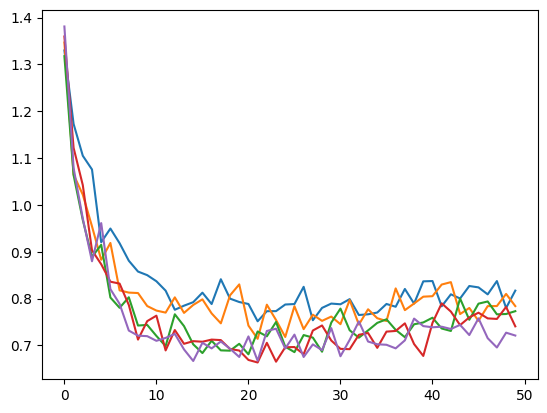

In [282]:
sns.lineplot(Eucl_test_loss_histories[0])
sns.lineplot(Eucl_test_loss_histories[1])
sns.lineplot(Eucl_test_loss_histories[2])
sns.lineplot(Eucl_test_loss_histories[3])
sns.lineplot(Eucl_test_loss_histories[4])

In [283]:
Eucl_test_acc_histories = []
Eucl_test_acc_histories.append(test_acc_list[150:200])
Eucl_test_acc_histories.append(test_acc_list[200:250])
Eucl_test_acc_histories.append(test_acc_list[250:300])
Eucl_test_acc_histories.append(test_acc_list[300:350])
Eucl_test_acc_histories.append(test_acc_list[350:400])

Hyp_test_acc_histories = []
Hyp_test_acc_histories.append(test_acc_list[0:50])
Hyp_test_acc_histories.append(test_acc_list[50:100])
Hyp_test_acc_histories.append(test_acc_list[100:150])
Hyp_test_acc_histories.append(test_acc_list[400:450])
Hyp_test_acc_histories.append(test_acc_list[450:500])

In [297]:
Hyp_N_params = [662511,1192391,1653159,2040243,2788545]
Eucl_N_params = [662300,1192125,1652838,2039867,2788114]

In [294]:
import matplotlib.pyplot as plt

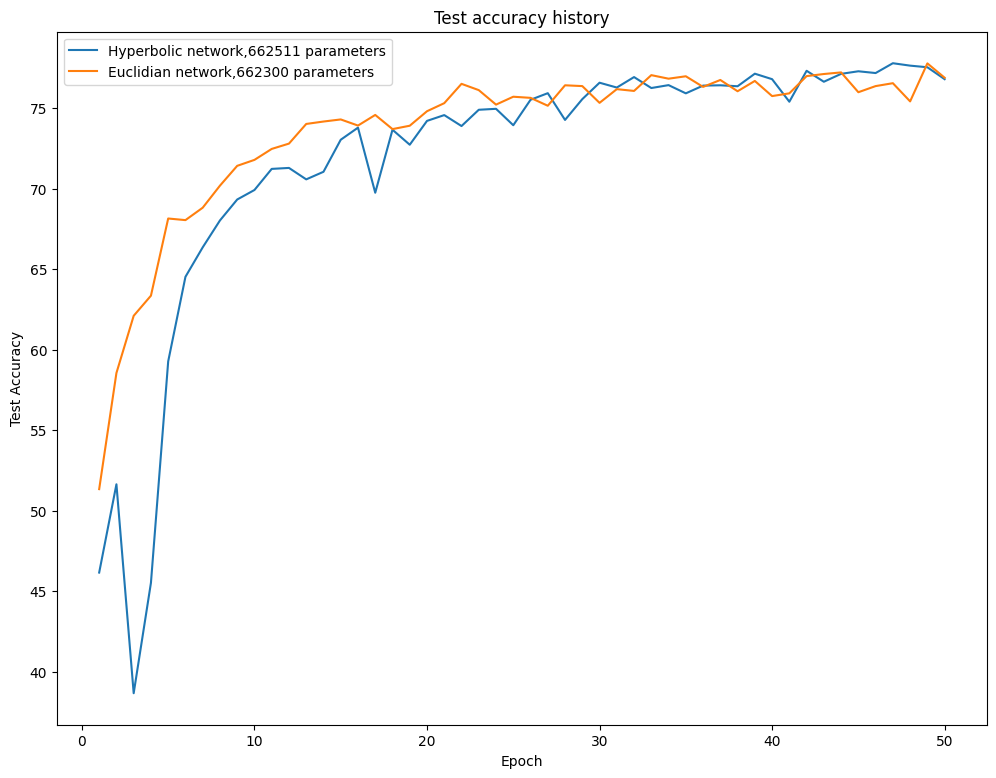

In [303]:
plt.figure(figsize=(12, 9))

plt.plot(np.arange(1,51),Hyp_test_acc_histories[0],label=f'Hyperbolic network,{Hyp_N_params[0]} parameters')
plt.plot(np.arange(1,51),Eucl_test_acc_histories[0],label=f'Euclidian network,{Eucl_N_params[0]} parameters')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy history')

plt.legend()

plt.savefig('Acc_hist_0.png')

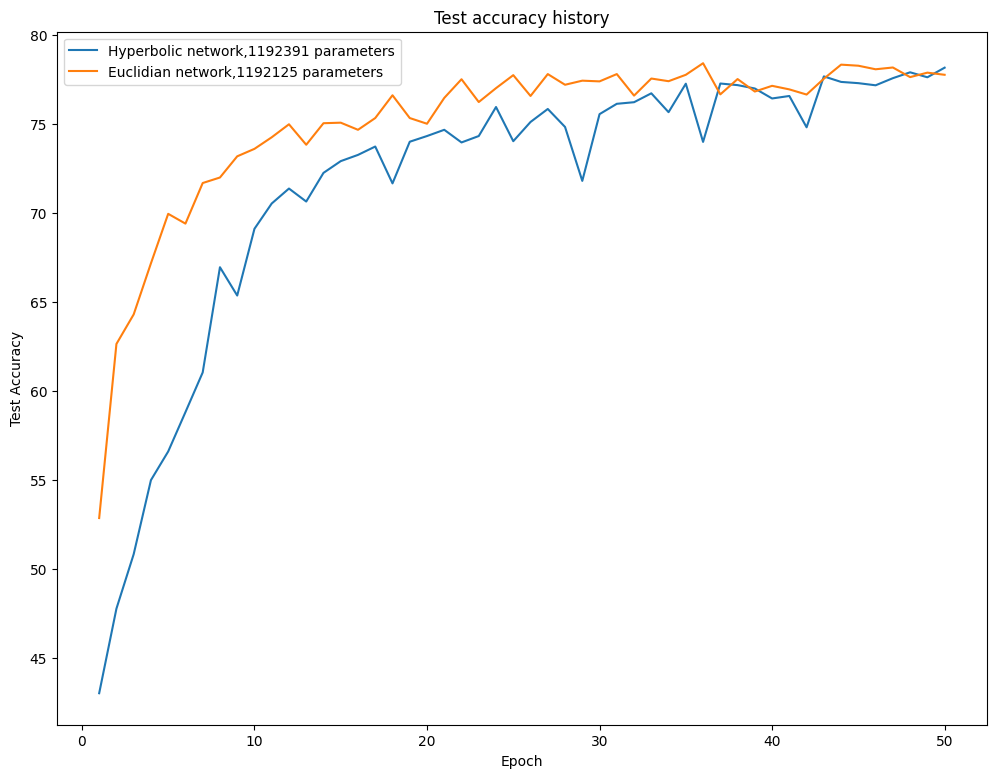

In [304]:
n = 1
plt.figure(figsize=(12, 9))

plt.plot(np.arange(1,51),Hyp_test_acc_histories[n],label=f'Hyperbolic network,{Hyp_N_params[n]} parameters')
plt.plot(np.arange(1,51),Eucl_test_acc_histories[n],label=f'Euclidian network,{Eucl_N_params[n]} parameters')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy history')

plt.legend()

plt.savefig(f'Acc_hist_{n}.png')

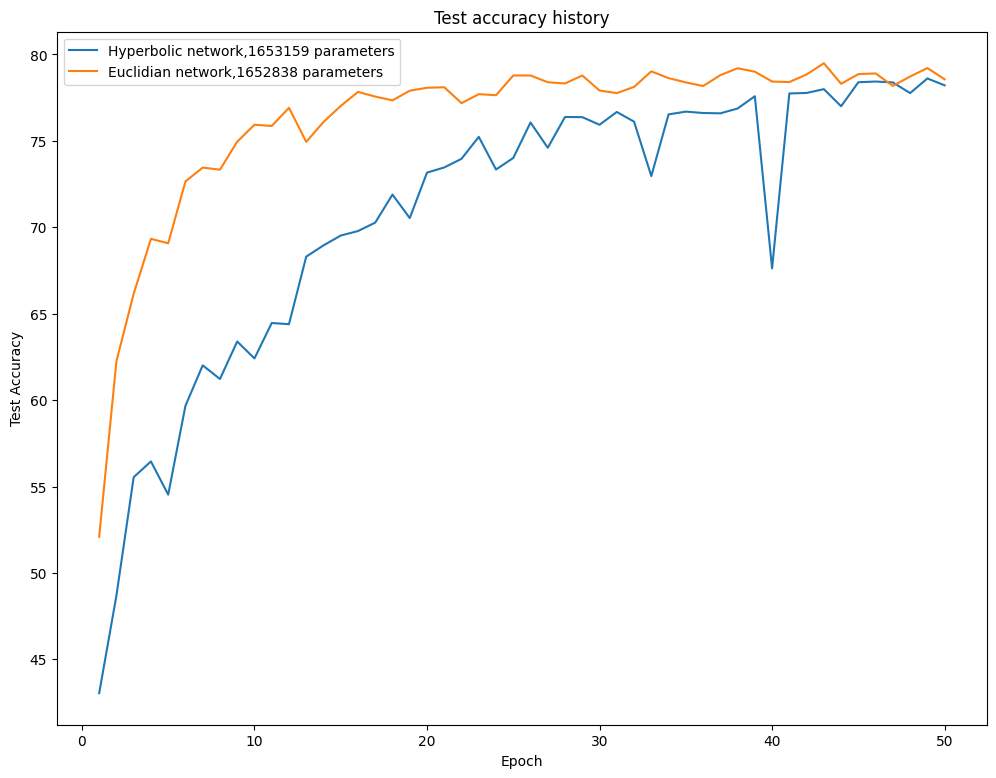

In [305]:
n = 2
plt.figure(figsize=(12, 9))

plt.plot(np.arange(1,51),Hyp_test_acc_histories[n],label=f'Hyperbolic network,{Hyp_N_params[n]} parameters')
plt.plot(np.arange(1,51),Eucl_test_acc_histories[n],label=f'Euclidian network,{Eucl_N_params[n]} parameters')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy history')

plt.legend()

plt.savefig(f'Acc_hist_{n}.png')

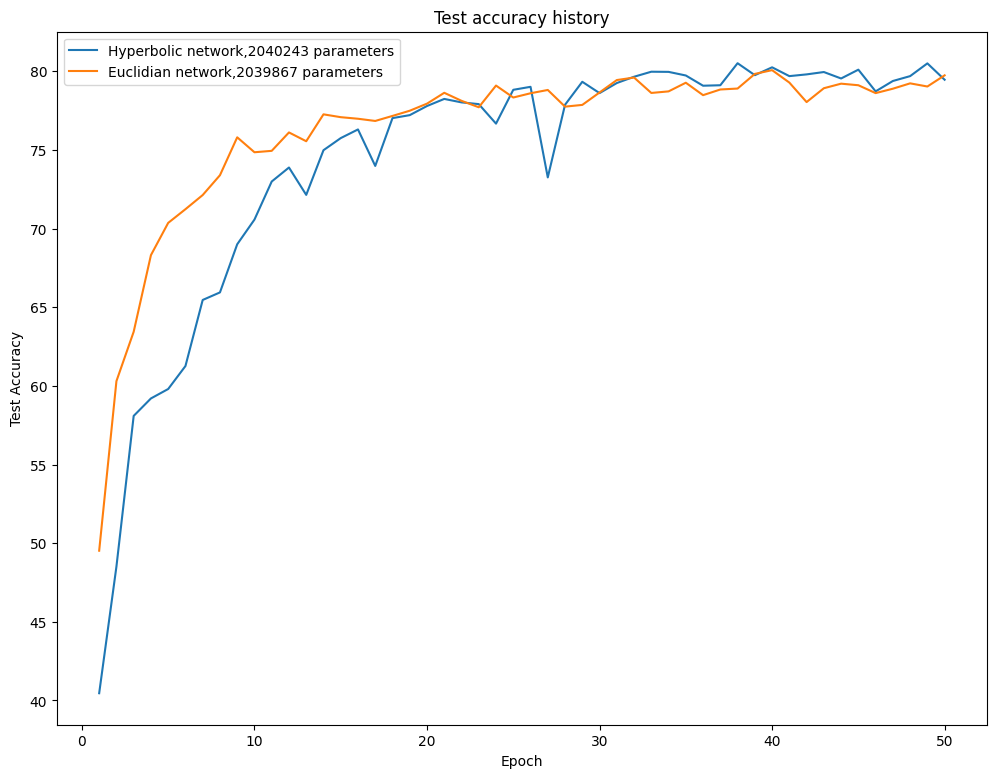

In [306]:
n = 3
plt.figure(figsize=(12, 9))

plt.plot(np.arange(1,51),Hyp_test_acc_histories[n],label=f'Hyperbolic network,{Hyp_N_params[n]} parameters')
plt.plot(np.arange(1,51),Eucl_test_acc_histories[n],label=f'Euclidian network,{Eucl_N_params[n]} parameters')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy history')

plt.legend()

plt.savefig(f'Acc_hist_{n}.png')

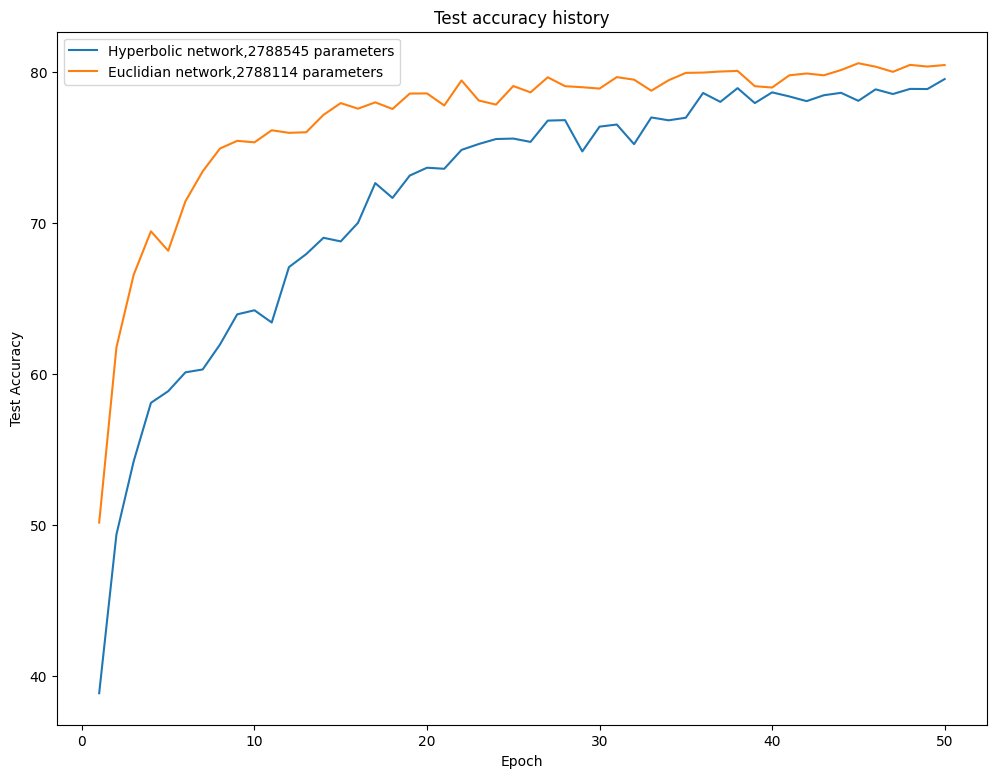

In [307]:
n = 4
plt.figure(figsize=(12, 9))

plt.plot(np.arange(1,51),Hyp_test_acc_histories[n],label=f'Hyperbolic network,{Hyp_N_params[n]} parameters')
plt.plot(np.arange(1,51),Eucl_test_acc_histories[n],label=f'Euclidian network,{Eucl_N_params[n]} parameters')

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy history')

plt.legend()

plt.savefig(f'Acc_hist_{n}.png')

In [312]:
Eucl_acc_means = []
Eucl_acc_stds = []

Hyp_acc_means = []
Hyp_acc_stds = []

Navg = 7

for i in range(5):
    Hyp_acc_means.append(np.mean(Hyp_test_acc_histories[i][-Navg:]))
    Hyp_acc_stds.append(np.std(Hyp_test_acc_histories[i][-Navg:]))

    Eucl_acc_means.append(np.mean(Eucl_test_acc_histories[i][-Navg:]))
    Eucl_acc_stds.append(np.std(Eucl_test_acc_histories[i][-Navg:]))

Eucl_acc_means = np.array(Eucl_acc_means)
Eucl_acc_stds = np.array(Eucl_acc_stds)

Hyp_acc_means = np.array(Hyp_acc_means)
Hyp_acc_stds = np.array(Hyp_acc_stds)

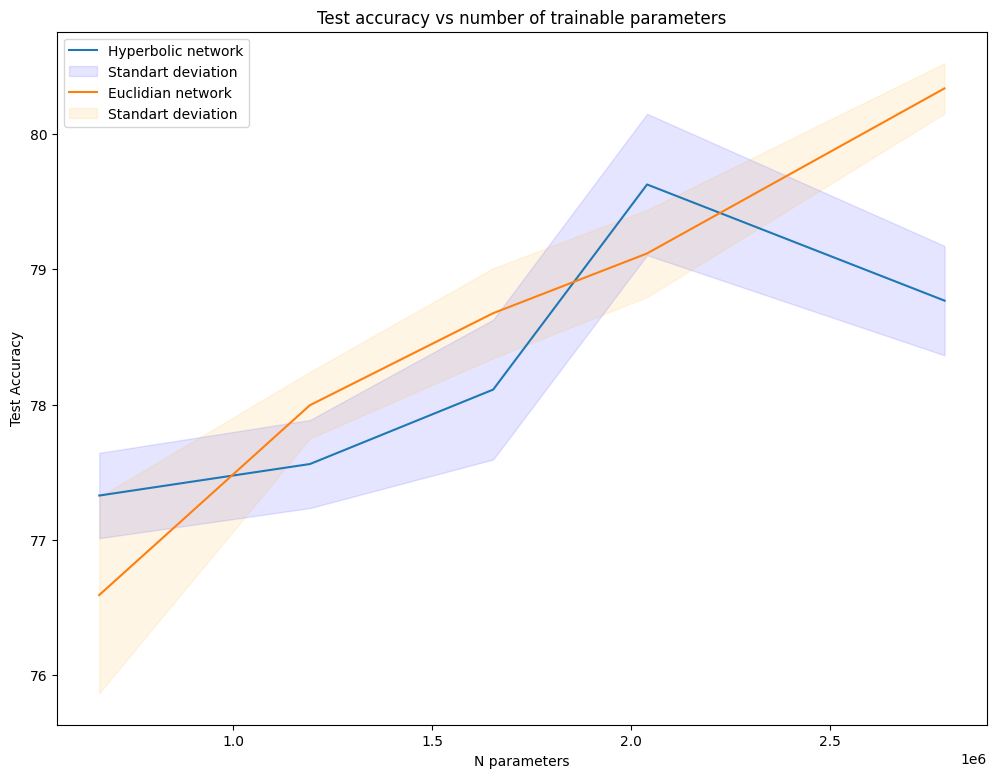

In [315]:
plt.figure(figsize=(12, 9))

plt.plot(Hyp_N_params,Hyp_acc_means,label='Hyperbolic network')

plt.fill_between(Hyp_N_params, 
                 (Hyp_acc_means - Hyp_acc_stds), 
                 (Hyp_acc_means + Hyp_acc_stds), 
                 color='blue', alpha=0.1, label='Standart deviation')

plt.plot(Eucl_N_params,Eucl_acc_means,label='Euclidian network')

plt.fill_between(Eucl_N_params, 
                 (Eucl_acc_means - Eucl_acc_stds), 
                 (Eucl_acc_means + Eucl_acc_stds), 
                 color='orange', alpha=0.1, label='Standart deviation')

plt.xlabel('N parameters')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy vs number of trainable parameters')

plt.legend()

plt.savefig('AccVsNparams.png')

In [325]:
Hyp_acc_means_copy = Hyp_acc_means.copy()
Hyp_acc_stds_copy = Hyp_acc_stds.copy()

Hyp_acc_means_copy[-1] = np.mean(test_acc_list[-7:])
Hyp_acc_stds_copy[-1] = np.std(test_acc_list[-7:])

New plot with more training for the largest hyperbolic network

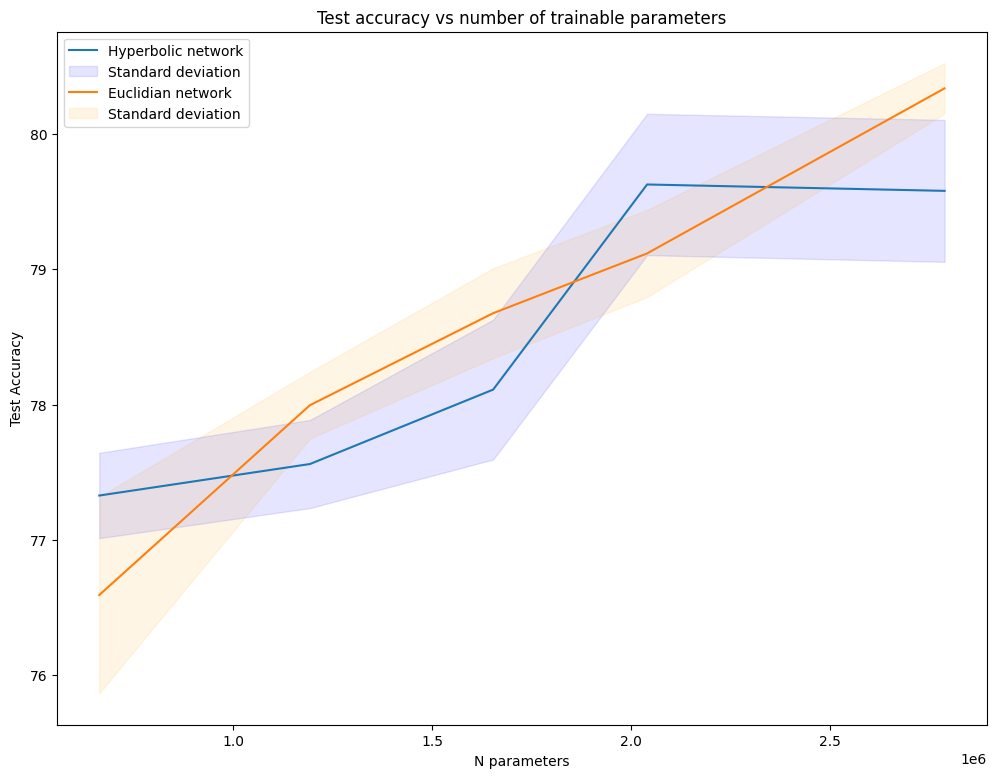

In [326]:
plt.figure(figsize=(12, 9))

plt.plot(Hyp_N_params,Hyp_acc_means_copy,label='Hyperbolic network')

plt.fill_between(Hyp_N_params, 
                 (Hyp_acc_means_copy - Hyp_acc_stds_copy), 
                 (Hyp_acc_means_copy + Hyp_acc_stds_copy), 
                 color='blue', alpha=0.1, label='Standard deviation')

plt.plot(Eucl_N_params,Eucl_acc_means,label='Euclidian network')

plt.fill_between(Eucl_N_params, 
                 (Eucl_acc_means - Eucl_acc_stds), 
                 (Eucl_acc_means + Eucl_acc_stds), 
                 color='orange', alpha=0.1, label='Standard deviation')

plt.xlabel('N parameters')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy vs number of trainable parameters')

plt.legend()

plt.savefig('AccVsNparams.png')

Training large hyperbolic network (right point) didn't give much.

In [330]:
Eucl_acc_maxs = []
Eucl_acc_mins = []

Hyp_acc_maxs = []
Hyp_acc_mins = []

Navg = 5

for i in range(5):
    Hyp_acc_mins.append(np.min(Hyp_test_acc_histories[i][-Navg:]))
    Hyp_acc_maxs.append(np.max(Hyp_test_acc_histories[i][-Navg:]))

    Eucl_acc_mins.append(np.min(Eucl_test_acc_histories[i][-Navg:]))
    Eucl_acc_maxs.append(np.max(Eucl_test_acc_histories[i][-Navg:]))

Eucl_acc_maxs = np.array(Eucl_acc_maxs)
Eucl_acc_mins = np.array(Eucl_acc_mins)

Hyp_acc_max = np.array(Hyp_acc_max)
Hyp_acc_mins = np.array(Hyp_acc_mins)

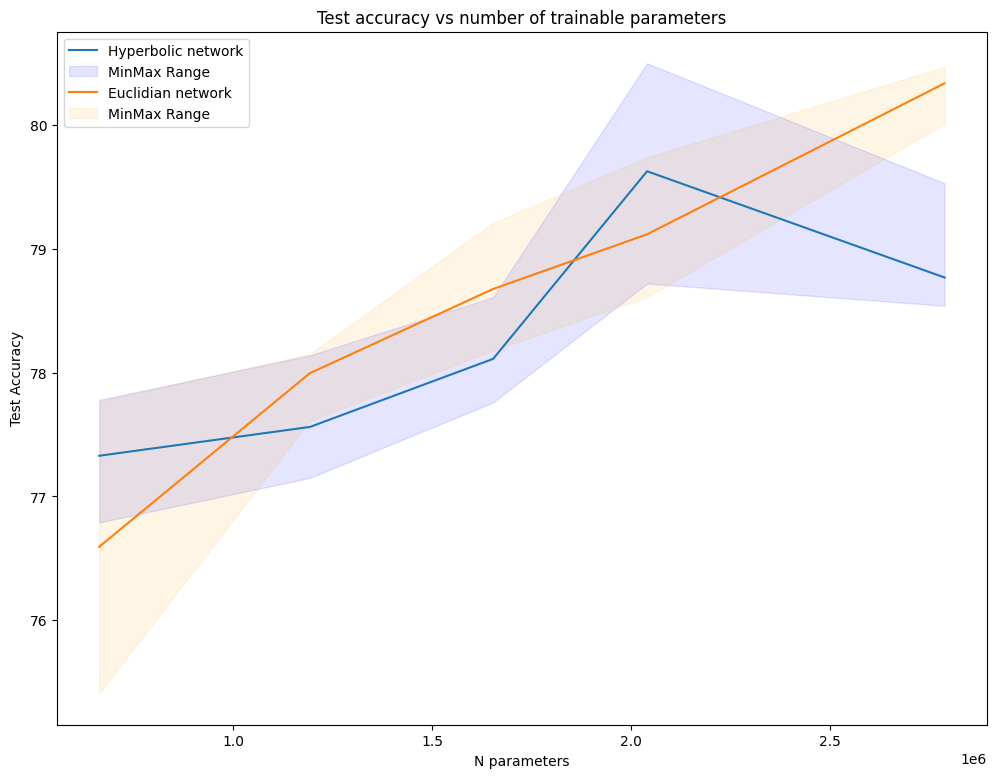

In [331]:
plt.figure(figsize=(12, 9))

plt.plot(Hyp_N_params,Hyp_acc_means,label='Hyperbolic network')

plt.fill_between(Hyp_N_params, 
                 (Hyp_acc_mins), 
                 (Hyp_acc_maxs), 
                 color='blue', alpha=0.1, label='MinMax Range')

plt.plot(Eucl_N_params,Eucl_acc_means,label='Euclidian network')

plt.fill_between(Eucl_N_params, 
                 (Eucl_acc_mins), 
                 (Eucl_acc_maxs), 
                 color='orange', alpha=0.1, label='MinMax Range')

plt.xlabel('N parameters')
plt.ylabel('Test Accuracy')
plt.title('Test accuracy vs number of trainable parameters')

plt.legend()

plt.savefig('AccVsNparamsMinMax.png')